In [7]:
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob


from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [8]:
train_data_dir = '/content/drive/MyDrive/shim 22-4-21/train'
img_width, img_height = 299, 299 
batch_size = 32

In [9]:
valid_data_dir = '/content/drive/MyDrive/shim 22-4-21/test'
img_width, img_height = 299, 299 
batch_size = 32

In [10]:
image_datagen = ImageDataGenerator(
    rescale=1./255, 
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
    #channel_shift_range=0.1
)

In [11]:
train_gen = image_datagen.flow_from_directory(
        train_data_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="training")
valid_gen = image_datagen.flow_from_directory(
        valid_data_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="validation")

Found 4322 images belonging to 9 classes.
Found 216 images belonging to 9 classes.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Callbacks
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto' 
)
csvlogger = CSVLogger( 
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduce = ReduceLROnPlateau( 
    monitor='val_loss',
    factor=0.1, 
    patience=3, #kac epoch iyilesmezse learning rate düssün
    verbose=1, 
    mode='auto',
)    

In [14]:
second_dense_512 = [0, 1]
dropout = [0, 1]

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print('Loaded model!')

87924736/87910968 [==============================] - 0s 0us/step
Loaded model!


In [15]:
import time

In [16]:
# Freeze the layers in base_model 
for layer in base_model.layers:
    layer.trainable = False 
        
# for dense2 in second_dense_512:
#     for drop in dropout:
drop = 1
dense2= 1
        
NAME = "flowers-inception-dense{}-drop{}-{}".format(dense2, drop, int(time.time()))
print(NAME)
logdir = "logs/flowers-inception/{}/".format(NAME)

# Callbacks
checkpoint = ModelCheckpoint(
    '{}base.model'.format(logdir),
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only = True,
    verbose = 1)
tensorboard = TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
if drop == 1 : x = Dropout(0.3)(x)
if dense2 == 1 : 
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if drop == 1 : x = Dropout(0.3)(x)

predictions = Dense(9, activation='softmax')(x)

model = Model(base_model.input, predictions)


model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# Take a look at layers of model
'''
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) )
'''

history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // train_gen.batch_size, #normalde len(X_train) / batch_size,
    epochs= 20,
    validation_data = valid_gen,
    validation_steps=valid_gen.n // valid_gen.batch_size, # normalde len(X_valid) / batch_size,
    verbose=1,
    callbacks=[checkpoint,tensorboard,csvlogger,reduce,earlystop])

        

'''
model.load_weights(best_model_finetuned_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss)) 
'''

flowers-inception-dense1-drop1-1628493308


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
135/135 [==============================] - 1605s 11s/step - loss: 0.9340 - accuracy: 0.7023 - val_loss: 0.3339 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.33394, saving model to logs/flowers-inception/flowers-inception-dense1-drop1-1628493308/base.model
Epoch 2/20
135/135 [==============================] - 95s 702ms/step - loss: 0.2690 - accuracy: 0.9142 - val_loss: 0.2334 - val_accuracy: 0.9323

Epoch 00002: val_loss improved from 0.33394 to 0.23340, saving model to logs/flowers-inception/flowers-inception-dense1-drop1-1628493308/base.model
Epoch 3/20
135/135 [==============================] - 95s 704ms/step - loss: 0.1889 - accuracy: 0.9373 - val_loss: 0.1993 - val_accuracy: 0.9219

Epoch 00003: val_loss improved from 0.23340 to 0.19930, saving model to logs/flowers-inception/flowers-inception-dense1-drop1-1628493308/base.model
Epoch 4/20
135/135 [==============================] - 98s 726ms/step - loss: 0.1590 - accuracy: 0.9450 - val_loss: 0.1653 

'\nmodel.load_weights(best_model_finetuned_path)  \n   \n(eval_loss, eval_accuracy) = model.evaluate(  \n     X_test, y_test, batch_size=batch_size, verbose=1)\n\nprint("Accuracy: {:.2f}%".format(eval_accuracy * 100))  \nprint("Loss: {}".format(eval_loss)) \n'

In [17]:
score = model.evaluate_generator(valid_gen)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


## ACCURACY

In [18]:
print(' loss:', score[0])
print('Accuracy:', score[1])

 loss: 0.06873985379934311
Accuracy: 0.9814814925193787


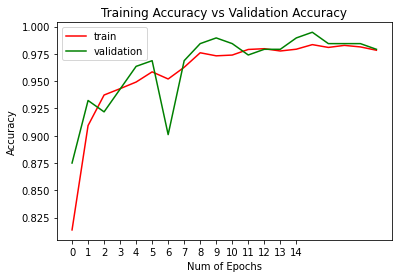

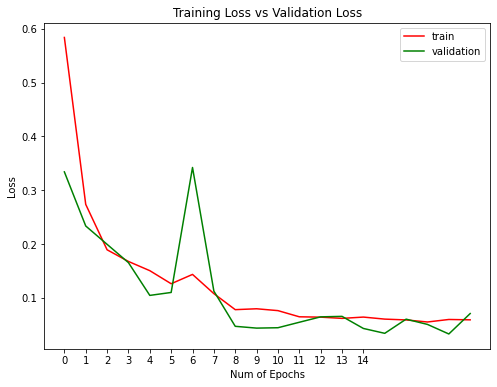

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 15, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [22]:
predictions = model.predict_generator(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


ValueError: ignored

In [ ]:
plt.imshow(predict[0][0][0])

In [ ]:
# print(predictions[0])

In [ ]:
import os 
def get_category(predicted_output):
    path ="/content/drive/MyDrive/shim 22-4-21/test"
    return os.listdir(path)[np.argmax(predicted_output)]

In [ ]:
print(get_category(predictions[34]))

In [ ]:
from matplotlib.pyplot import imshow

In [ ]:
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(predict[2][0][0])
axs[0][0].set_title(get_category(predictions[2]))
axs[0][1].imshow(predict[1][0][0])
axs[0][1].set_title(get_category(predictions[1]))
axs[0][2].imshow(predict[4][0][0])
axs[0][2].set_title(get_category(predictions[4]))
axs[1][0].imshow(predict[3][0][0])
axs[1][0].set_title(get_category(predictions[3]))
axs[1][1].imshow(predict[1][0][0])
axs[1][1].set_title(get_category(predictions[1]))
axs[1][2].imshow(predict[2][0][0])
axs[1][2].set_title(get_category(predictions[2]))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
Y_pred = model.predict_generator(valid_gen)

y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
import itertools  

In [ ]:
target_names = []

for key in train_gen.class_indices:

    target_names.append(key)

In [ ]:
cm = confusion_matrix(valid_gen.classes, y_pred)

In [ ]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
print('Classification Report')

print(classification_report(valid_gen.classes, y_pred, target_names=target_names))

In [ ]:

def plot_model_history(history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(history.history[acc])+1),history.history[acc])
    axs[0].plot(range(1,len(history.history[val_acc])+1),history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history[acc])+1),len(history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(history.history['loss'])+1),history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
plot_model_history(history)